In [56]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import os
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam, SGD

##############################################
# Parameters & Setup
##############################################
seq_len = 10
embedding_dim = 8
batch_size = 64
data_dir = 'split_data_parquet'

player_columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID"
]

main_out_column = "OUTCOME"
second_chance_column = "SECOND_CHANCE"
unwanted_cols = ["SHOOTER_ID","ASSISTER_ID","BLOCKER_ID","STEALER_ID","REBOUNDER_ID","TURNOVER_ID"]

# Identify shard files
train_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('train_') and f.endswith('.parquet')])
val_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('val_') and f.endswith('.parquet')])
test_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('test_') and f.endswith('.parquet')])

##############################################
# Build Player ID Mapping
##############################################
def gather_unique_player_ids(files, player_cols):
    unique_ids = set()
    for fpath in files:
        print(f"Scanning file for unique IDs: {fpath}")
        df = pd.read_parquet(fpath, columns=player_cols)  # load only player columns
        df = df.dropna(subset=player_cols)
        for col in player_cols:
            unique_ids.update(df[col].dropna().astype(int).unique())
    return unique_ids

all_files = train_files + val_files + test_files
all_unique_ids = gather_unique_player_ids(all_files, player_columns)

unique_players = np.sort(list(all_unique_ids))
player_to_index = {p: i for i, p in enumerate(unique_players)}
v = len(unique_players)
print(f"Number of unique players: {v}")
print("Example mapping:", list(player_to_index.items())[:10])

##############################################
# Model Definition Using Embeddings (with updated v)
##############################################
input_players = Input(shape=(seq_len,), dtype='int32', name='players_input')
player_embedding = layers.Embedding(input_dim=v, output_dim=embedding_dim, name='player_embedding')(input_players)

offense_emb = layers.Lambda(lambda t: t[:, :5, :], name='offense_slice')(player_embedding)
defense_emb = layers.Lambda(lambda t: t[:, 5:, :], name='defense_slice')(player_embedding)

off_mean = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1), name='off_mean')(offense_emb)
def_mean = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1), name='def_mean')(defense_emb)

concat = layers.Concatenate(name='concat')([off_mean, def_mean])
hidden = layers.Dense(128, activation='relu', name='hidden')(concat)

main_out = layers.Dense(14, activation='softmax', name='main_out')(hidden)
second_chance_out = layers.Dense(1, activation='sigmoid', name='second_chance_out')(hidden)

# Set a custom learning rate
# optimizer = Adam(learning_rate=0.0001)
optimizer = SGD(learning_rate=0.01, momentum=0.9)

model = Model(inputs=input_players, outputs=[main_out, second_chance_out])
model.compile(
    optimizer=optimizer,
    loss={
        'main_out': 'categorical_crossentropy',
        'second_chance_out': 'binary_crossentropy'
    },
    metrics={
        'main_out': 'accuracy',
        'second_chance_out': 'accuracy'
    }
)

model.summary()

##############################################
# Utility Functions for tf.data Pipeline
##############################################
def shard_generator(file_list, main_col, sc_col, mapping):
    """
    Yields individual samples (X, (y_main, y_sc)) from shard files.
    Applies player_to_index mapping to ensure IDs are in [0, v-1].
    """
    for fpath in file_list:
        print(f"Loading shard: {fpath}")
        df = pd.read_parquet(fpath)

        # Drop rows with NaNs in player columns
        df = df.dropna(subset=player_columns)

        # Convert players to int
        for col in player_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

        # Drop unwanted columns
        for c in unwanted_cols:
            if c in df.columns:
                df.drop(columns=c, inplace=True)

        # One-hot the outcome column
        categories = sorted(df[main_col].unique())
        cat_to_idx = {cat: i for i, cat in enumerate(categories)}

        num_samples = len(df)
        y_main = np.zeros((num_samples, 14), dtype='float32')
        for i, val in enumerate(df[main_col]):
            class_idx = cat_to_idx[val]
            y_main[i, class_idx] = 1.0

        y_sc = df[sc_col].astype(int).values.reshape(-1, 1)

        # Drop target columns now
        df.drop(columns=[main_col, sc_col], inplace=True)

        # Map player IDs
        for c in player_columns:
            df[c] = df[c].map(mapping)

        X = df[player_columns].values.astype(np.int32)

        # Yield each sample
        for i in range(num_samples):
            yield X[i], (y_main[i], y_sc[i])

def create_dataset(file_list, main_col, sc_col, batch_size, mapping, shuffle_buffer=10000):
    ds = tf.data.Dataset.from_generator(
        lambda: shard_generator(file_list, main_col, sc_col, mapping),
        output_types=(tf.int32, (tf.float32, tf.float32)),
        output_shapes=((seq_len,), ((14,), (1,)))
    )

    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

##############################################
# Create Datasets using mapping
##############################################
train_ds = create_dataset(train_files, main_out_column, second_chance_column, batch_size, player_to_index)
val_ds = create_dataset(val_files, main_out_column, second_chance_column, batch_size, player_to_index)
test_ds = create_dataset(test_files, main_out_column, second_chance_column, batch_size, player_to_index)

##############################################
# Training with tf.data
##############################################
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

##############################################
# Evaluation
##############################################
model.evaluate(test_ds)

Scanning file for unique IDs: split_data_parquet/train_000.parquet
Scanning file for unique IDs: split_data_parquet/train_001.parquet
Scanning file for unique IDs: split_data_parquet/train_002.parquet
Scanning file for unique IDs: split_data_parquet/train_003.parquet
Scanning file for unique IDs: split_data_parquet/train_004.parquet
Scanning file for unique IDs: split_data_parquet/train_005.parquet
Scanning file for unique IDs: split_data_parquet/train_006.parquet
Scanning file for unique IDs: split_data_parquet/train_007.parquet
Scanning file for unique IDs: split_data_parquet/train_008.parquet
Scanning file for unique IDs: split_data_parquet/train_009.parquet
Scanning file for unique IDs: split_data_parquet/val_000.parquet
Scanning file for unique IDs: split_data_parquet/val_001.parquet
Scanning file for unique IDs: split_data_parquet/test_000.parquet
Scanning file for unique IDs: split_data_parquet/test_001.parquet
Number of unique players: 961
Example mapping: [(1713, 0), (2544, 1)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ players_input       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (None, 10, 8)     │      7,688 │ players_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ offense_slice       │ (None, 5, 8)      │          0 │ player_embedding… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defense_slice       │ (None, 5, 8)      │          0 │ player_embedding… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ off_mean (Lambda)   │ (None, 8)         │          0 │ offense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ def_mean (Lambda)   │ (None, 8)         │          0 │ defense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 16)        │          0 │ off_mean[0][0],   │
│ (Concatenate)       │                   │            │ def_mean[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden (Dense)      │ (None, 128)       │      2,176 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_out (Dense)    │ (None, 14)        │      1,806 │ hidden[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_chance_out   │ (None, 1)         │        129 │ hidden[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,799 (46.09 KB)

 Trainable params: 11,799 (46.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
Loading shard: split_data_parquet/train_000.parquet
   1757/Unknown 9s 4ms/step - loss: 2.4787 - main_out_accuracy: 0.3572 - main_out_loss: 2.1129 - second_chance_out_accuracy: 0.8871 - second_chance_out_loss: 0.3658Loading shard: split_data_parquet/train_001.parquet
   3669/Unknown 17s 4ms/step - loss: 2.4464 - main_out_accuracy: 0.3592 - main_out_loss: 2.0875 - second_chance_out_accuracy: 0.8876 - second_chance_out_loss: 0.3589Loading shard: split_data_parquet/train_002.parquet
   5587/Unknown 25s 4ms/step - loss: 2.4331 - main_out_accuracy: 0.3599 - main_out_loss: 2.0767 - second_chance_out_accuracy: 0.8877 - second_chance_out_loss: 0.3564Loading shard: split_data_parquet/train_003.parquet
   7503/Unknown 34s 4ms/step - loss: 2.4253 - main_out_accuracy: 0.3604 - main_out_loss: 2.0702 - second_chance_out_accuracy: 0.8878 - second_chance_out_loss: 0.3551Loading shard: split_data_parquet/train_004.parquet
   9409/Unknown 42s 4ms/step - loss: 2.4203 - main_out_accuracy: 0.360

/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 95s 5ms/step - loss: 2.4087 - main_out_accuracy: 0.3611 - main_out_loss: 2.0558 - second_chance_out_accuracy: 0.8878 - second_chance_out_loss: 0.3529 - val_loss: 2.3873 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0347 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3516
Epoch 2/10


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1751/19153 ━━━━━━━━━━━━━━━━━━━━ 1:13 4ms/step - loss: 2.3844 - main_out_accuracy: 0.3602 - main_out_loss: 2.0362 - second_chance_out_accuracy: 0.8890 - second_chance_out_loss: 0.3482Loading shard: split_data_parquet/train_001.parquet
 3664/19153 ━━━━━━━━━━━━━━━━━━━━ 1:06 4ms/step - loss: 2.3856 - main_out_accuracy: 0.3608 - main_out_loss: 2.0366 - second_chance_out_accuracy: 0.8886 - second_chance_out_loss: 0.3490Loading shard: split_data_parquet/train_002.parquet
 5586/19153 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - loss: 2.3859 - main_out_accuracy: 0.3609 - main_out_loss: 2.0366 - second_chance_out_accuracy: 0.8884 - second_chance_out_loss: 0.3494Loading shard: split_data_parquet/train_003.parquet
 7497/19153 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - loss: 2.3858 - main_out_accuracy: 0.3612 - main_out_loss: 2.0363 - second_chance_out_accuracy: 0.8884 - second_chance_out_loss: 0.3495Loading shard: split_data_parquet/train_004.parquet
 9409/1915

/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 94s 5ms/step - loss: 2.3858 - main_out_accuracy: 0.3615 - main_out_loss: 2.0357 - second_chance_out_accuracy: 0.8880 - second_chance_out_loss: 0.3502 - val_loss: 2.3832 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0306 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3515
Epoch 3/10


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1753/19153 ━━━━━━━━━━━━━━━━━━━━ 1:15 4ms/step - loss: 2.3796 - main_out_accuracy: 0.3594 - main_out_loss: 2.0330 - second_chance_out_accuracy: 0.8895 - second_chance_out_loss: 0.3466Loading shard: split_data_parquet/train_001.parquet
 3667/19153 ━━━━━━━━━━━━━━━━━━━━ 1:06 4ms/step - loss: 2.3813 - main_out_accuracy: 0.3603 - main_out_loss: 2.0333 - second_chance_out_accuracy: 0.8889 - second_chance_out_loss: 0.3481Loading shard: split_data_parquet/train_002.parquet
 5582/19153 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - loss: 2.3819 - main_out_accuracy: 0.3606 - main_out_loss: 2.0333 - second_chance_out_accuracy: 0.8886 - second_chance_out_loss: 0.3486Loading shard: split_data_parquet/train_003.parquet
 7502/19153 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - loss: 2.3819 - main_out_accuracy: 0.3609 - main_out_loss: 2.0330 - second_chance_out_accuracy: 0.8885 - second_chance_out_loss: 0.3488Loading shard: split_data_parquet/train_004.parquet
 9409/1915

/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 94s 5ms/step - loss: 2.3823 - main_out_accuracy: 0.3614 - main_out_loss: 2.0326 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3497 - val_loss: 2.3826 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0300 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3517
Epoch 4/10


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1752/19153 ━━━━━━━━━━━━━━━━━━━━ 1:15 4ms/step - loss: 2.3770 - main_out_accuracy: 0.3595 - main_out_loss: 2.0310 - second_chance_out_accuracy: 0.8898 - second_chance_out_loss: 0.3460Loading shard: split_data_parquet/train_001.parquet
 3667/19153 ━━━━━━━━━━━━━━━━━━━━ 1:07 4ms/step - loss: 2.3787 - main_out_accuracy: 0.3604 - main_out_loss: 2.0312 - second_chance_out_accuracy: 0.8890 - second_chance_out_loss: 0.3475Loading shard: split_data_parquet/train_002.parquet
 5581/19153 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - loss: 2.3793 - main_out_accuracy: 0.3607 - main_out_loss: 2.0312 - second_chance_out_accuracy: 0.8887 - second_chance_out_loss: 0.3481Loading shard: split_data_parquet/train_003.parquet
 7497/19153 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 2.3794 - main_out_accuracy: 0.3610 - main_out_loss: 2.0310 - second_chance_out_accuracy: 0.8886 - second_chance_out_loss: 0.3484Loading shard: split_data_parquet/train_004.parquet
 9410/1915

/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 94s 5ms/step - loss: 2.3798 - main_out_accuracy: 0.3614 - main_out_loss: 2.0305 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3493 - val_loss: 2.3796 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0276 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3509
Epoch 5/10


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1753/19153 ━━━━━━━━━━━━━━━━━━━━ 1:14 4ms/step - loss: 2.3727 - main_out_accuracy: 0.3614 - main_out_loss: 2.0249 - second_chance_out_accuracy: 0.8887 - second_chance_out_loss: 0.3478Loading shard: split_data_parquet/train_001.parquet
 3666/19153 ━━━━━━━━━━━━━━━━━━━━ 1:06 4ms/step - loss: 2.3755 - main_out_accuracy: 0.3613 - main_out_loss: 2.0273 - second_chance_out_accuracy: 0.8885 - second_chance_out_loss: 0.3482Loading shard: split_data_parquet/train_002.parquet
 5579/19153 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - loss: 2.3764 - main_out_accuracy: 0.3613 - main_out_loss: 2.0279 - second_chance_out_accuracy: 0.8884 - second_chance_out_loss: 0.3484Loading shard: split_data_parquet/train_003.parquet
 7497/19153 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 2.3766 - main_out_accuracy: 0.3614 - main_out_loss: 2.0280 - second_chance_out_accuracy: 0.8883 - second_chance_out_loss: 0.3486Loading shard: split_data_parquet/train_004.parquet
 9411/1915

2024-12-09 22:15:26.376997: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 94s 5ms/step - loss: 2.3773 - main_out_accuracy: 0.3616 - main_out_loss: 2.0282 - second_chance_out_accuracy: 0.8880 - second_chance_out_loss: 0.3492 - val_loss: 2.3778 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0260 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3507
Epoch 6/10


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1750/19153 ━━━━━━━━━━━━━━━━━━━━ 1:15 4ms/step - loss: 2.3727 - main_out_accuracy: 0.3601 - main_out_loss: 2.0264 - second_chance_out_accuracy: 0.8893 - second_chance_out_loss: 0.3463Loading shard: split_data_parquet/train_001.parquet
 3665/19153 ━━━━━━━━━━━━━━━━━━━━ 1:07 4ms/step - loss: 2.3746 - main_out_accuracy: 0.3606 - main_out_loss: 2.0273 - second_chance_out_accuracy: 0.8888 - second_chance_out_loss: 0.3473Loading shard: split_data_parquet/train_002.parquet
 5580/19153 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - loss: 2.3752 - main_out_accuracy: 0.3608 - main_out_loss: 2.0275 - second_chance_out_accuracy: 0.8886 - second_chance_out_loss: 0.3477Loading shard: split_data_parquet/train_003.parquet
 7496/19153 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 2.3753 - main_out_accuracy: 0.3611 - main_out_loss: 2.0273 - second_chance_out_accuracy: 0.8885 - second_chance_out_loss: 0.3480Loading shard: split_data_parquet/train_004.parquet
 9410/1915

/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 94s 5ms/step - loss: 2.3759 - main_out_accuracy: 0.3614 - main_out_loss: 2.0271 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3488 - val_loss: 2.3775 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0254 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3509
Epoch 7/10


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1750/19153 ━━━━━━━━━━━━━━━━━━━━ 1:14 4ms/step - loss: 2.3695 - main_out_accuracy: 0.3616 - main_out_loss: 2.0232 - second_chance_out_accuracy: 0.8892 - second_chance_out_loss: 0.3463Loading shard: split_data_parquet/train_001.parquet
 3668/19153 ━━━━━━━━━━━━━━━━━━━━ 1:06 4ms/step - loss: 2.3723 - main_out_accuracy: 0.3614 - main_out_loss: 2.0251 - second_chance_out_accuracy: 0.8888 - second_chance_out_loss: 0.3472Loading shard: split_data_parquet/train_002.parquet
 5583/19153 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - loss: 2.3733 - main_out_accuracy: 0.3613 - main_out_loss: 2.0256 - second_chance_out_accuracy: 0.8885 - second_chance_out_loss: 0.3477Loading shard: split_data_parquet/train_003.parquet
 7496/19153 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 2.3736 - main_out_accuracy: 0.3615 - main_out_loss: 2.0256 - second_chance_out_accuracy: 0.8884 - second_chance_out_loss: 0.3479Loading shard: split_data_parquet/train_004.parquet
 9410/1915

/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 92s 5ms/step - loss: 2.3745 - main_out_accuracy: 0.3616 - main_out_loss: 2.0258 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3487 - val_loss: 2.3768 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0249 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3510
Epoch 8/10


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1756/19153 ━━━━━━━━━━━━━━━━━━━━ 1:12 4ms/step - loss: 2.3719 - main_out_accuracy: 0.3595 - main_out_loss: 2.0254 - second_chance_out_accuracy: 0.8891 - second_chance_out_loss: 0.3464Loading shard: split_data_parquet/train_001.parquet
 3673/19153 ━━━━━━━━━━━━━━━━━━━━ 1:05 4ms/step - loss: 2.3730 - main_out_accuracy: 0.3604 - main_out_loss: 2.0257 - second_chance_out_accuracy: 0.8887 - second_chance_out_loss: 0.3473Loading shard: split_data_parquet/train_002.parquet
 5588/19153 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - loss: 2.3734 - main_out_accuracy: 0.3607 - main_out_loss: 2.0258 - second_chance_out_accuracy: 0.8885 - second_chance_out_loss: 0.3476Loading shard: split_data_parquet/train_003.parquet
 7498/19153 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 2.3734 - main_out_accuracy: 0.3610 - main_out_loss: 2.0256 - second_chance_out_accuracy: 0.8884 - second_chance_out_loss: 0.3478Loading shard: split_data_parquet/train_004.parquet
 9411/1915

/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 92s 5ms/step - loss: 2.3739 - main_out_accuracy: 0.3614 - main_out_loss: 2.0253 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3486 - val_loss: 2.3771 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0251 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3509
Epoch 9/10


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1752/19153 ━━━━━━━━━━━━━━━━━━━━ 1:14 4ms/step - loss: 2.3684 - main_out_accuracy: 0.3606 - main_out_loss: 2.0229 - second_chance_out_accuracy: 0.8895 - second_chance_out_loss: 0.3455Loading shard: split_data_parquet/train_001.parquet
 3670/19153 ━━━━━━━━━━━━━━━━━━━━ 1:06 4ms/step - loss: 2.3711 - main_out_accuracy: 0.3609 - main_out_loss: 2.0242 - second_chance_out_accuracy: 0.8888 - second_chance_out_loss: 0.3469Loading shard: split_data_parquet/train_002.parquet
 5582/19153 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - loss: 2.3720 - main_out_accuracy: 0.3610 - main_out_loss: 2.0246 - second_chance_out_accuracy: 0.8886 - second_chance_out_loss: 0.3474Loading shard: split_data_parquet/train_003.parquet
 7495/19153 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 2.3722 - main_out_accuracy: 0.3612 - main_out_loss: 2.0245 - second_chance_out_accuracy: 0.8885 - second_chance_out_loss: 0.3477Loading shard: split_data_parquet/train_004.parquet
 9409/1915

/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 93s 5ms/step - loss: 2.3732 - main_out_accuracy: 0.3615 - main_out_loss: 2.0246 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3485 - val_loss: 2.3767 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0247 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3509
Epoch 10/10


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1752/19153 ━━━━━━━━━━━━━━━━━━━━ 1:14 4ms/step - loss: 2.3676 - main_out_accuracy: 0.3609 - main_out_loss: 2.0210 - second_chance_out_accuracy: 0.8889 - second_chance_out_loss: 0.3466Loading shard: split_data_parquet/train_001.parquet
 3666/19153 ━━━━━━━━━━━━━━━━━━━━ 1:06 4ms/step - loss: 2.3704 - main_out_accuracy: 0.3611 - main_out_loss: 2.0230 - second_chance_out_accuracy: 0.8886 - second_chance_out_loss: 0.3474Loading shard: split_data_parquet/train_002.parquet
 5581/19153 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - loss: 2.3714 - main_out_accuracy: 0.3611 - main_out_loss: 2.0236 - second_chance_out_accuracy: 0.8884 - second_chance_out_loss: 0.3477Loading shard: split_data_parquet/train_003.parquet
 7494/19153 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 2.3716 - main_out_accuracy: 0.3613 - main_out_loss: 2.0238 - second_chance_out_accuracy: 0.8884 - second_chance_out_loss: 0.3478Loading shard: split_data_parquet/train_004.parquet
 9410/1915

/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 93s 5ms/step - loss: 2.3727 - main_out_accuracy: 0.3615 - main_out_loss: 2.0241 - second_chance_out_accuracy: 0.8880 - second_chance_out_loss: 0.3486 - val_loss: 2.3763 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0246 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3508


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/test_000.parquet
   1033/Unknown 5s 4ms/step - loss: 2.3808 - main_out_accuracy: 0.3619 - main_out_loss: 2.0276 - second_chance_out_accuracy: 0.8861 - second_chance_out_loss: 0.3532Loading shard: split_data_parquet/test_001.parquet
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.3793 - main_out_accuracy: 0.3610 - main_out_loss: 2.0288 - second_chance_out_accuracy: 0.8873 - second_chance_out_loss: 0.3506


/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[2.3771352767944336,
 2.027186870574951,
 0.3486934006214142,
 0.3609445095062256,
 0.8881369233131409]

In [57]:
import pandas as pd

# After training the model and having player_to_index, unique_players defined:
embedding_matrix = model.get_layer('player_embedding').get_weights()[0]

# Create a DataFrame for player embeddings
# Columns: ['player_id', 'embed_0', 'embed_1', ..., 'embed_{embedding_dim-1}']
columns = ['player_id'] + [f'embed_{d}' for d in range(embedding_matrix.shape[1])]

data = []
for p, i in player_to_index.items():
    # embedding_matrix[i] is the embedding vector for player p
    row = [p] + embedding_matrix[i].tolist()
    data.append(row)

df = pd.DataFrame(data, columns=columns)

# Save to a CSV file
output_csv = 'player_embeddings.csv'
df.to_csv(output_csv, index=False)

print(f"Saved player embeddings to {output_csv}")

Saved player embeddings to player_embeddings.csv


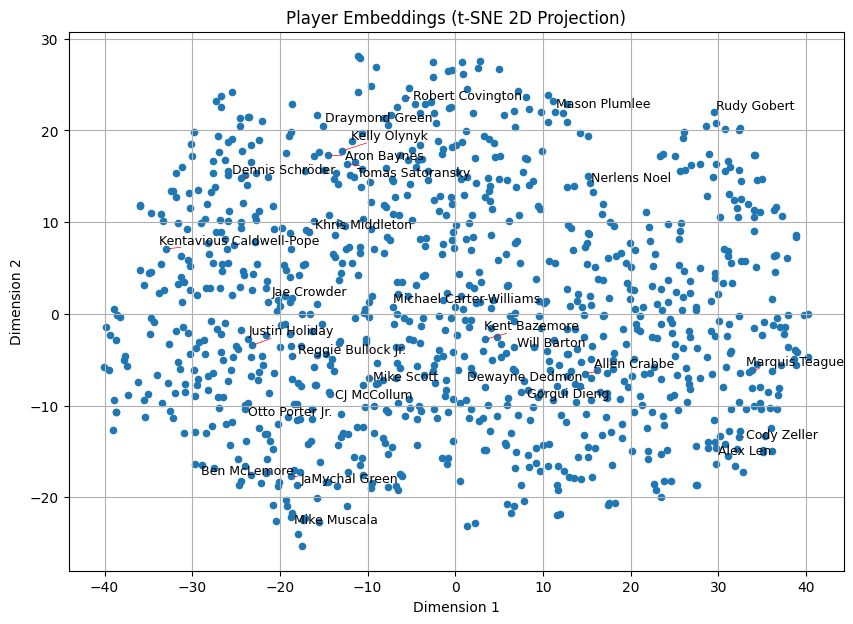

In [58]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nba_api.stats.static import players
from adjustText import adjust_text

# Load the embeddings from the CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure the CSV path is correct

player_ids = df['player_id'].values
# Extract embedding columns (all except 'player_id')
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Run TSNE on vectors
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne.fit_transform(vectors)

x_coords = tsne_coords[:, 0]
y_coords = tsne_coords[:, 1]

# Get NBA players list and create a dict id->full_name if your player_id matches nba_api ids
all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

plt.figure(figsize=(10, 7))
plt.scatter(x_coords, y_coords, s=20)

# We'll store text objects separately and then call adjust_text
texts = []

# Label the first 10 points (or any other selection logic)
for i, pid in enumerate(player_ids):
    if 100 < i < 130:
        label = id_to_name.get(pid, str(pid))
        # Instead of plt.text directly, we add them to a list
        text_obj = plt.text(x_coords[i], y_coords[i], label, fontsize=9)
        texts.append(text_obj)

plt.title("Player Embeddings (t-SNE 2D Projection)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)

# Adjust text positions to avoid overlap
adjust_text(texts, x=x_coords[:10], y=y_coords[:10], arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

plt.show()

In [59]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure correct path
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# LeBron James player_id in nba_api:
lebron_id = 2544
if lebron_id not in id_to_index:
    raise ValueError("LeBron James (player_id=2544) not found in embeddings CSV.")

lebron_idx = id_to_index[lebron_id]
lebron_vec = vectors[lebron_idx].reshape(1, -1)

# Compute cosine similarity between LeBron and all other players
similarities = cosine_similarity(lebron_vec, vectors)[0]  # shape (num_players,)

# Set LeBron's own similarity to -inf
similarities[lebron_idx] = -np.inf

# Sort by similarity
sorted_indices = np.argsort(similarities)[::-1]  # descending order
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to LeBron James:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to LeBron James:
1. Kristaps Porziņģis (ID: 204001), similarity: 0.9477
2. Chet Holmgren (ID: 1631096), similarity: 0.9294
3. Myles Turner (ID: 1626167), similarity: 0.8483
4. Chris Paul (ID: 101108), similarity: 0.8223
5. Mikal Bridges (ID: 1628969), similarity: 0.8152
6. Cason Wallace (ID: 1641717), similarity: 0.8138
7. Aaron Wiggins (ID: 1630598), similarity: 0.8034
8. Derrick Jones Jr. (ID: 1627884), similarity: 0.8011
9. Anthony Davis (ID: 203076), similarity: 0.8000
10. Kevin Durant (ID: 201142), similarity: 0.7814
11. Derrick White (ID: 1628401), similarity: 0.7668
12. Jaren Jackson Jr. (ID: 1628991), similarity: 0.7645
13. Jalen Johnson (ID: 1630552), similarity: 0.7630
14. Vasilije Micić (ID: 203995), similarity: 0.7483
15. P.J. Washington (ID: 1629023), similarity: 0.7330
16. Herbert Jones (ID: 1630529), similarity: 0.7326
17. Evan Mobley (ID: 1630596), similarity: 0.7313
18. Marco Belinelli (ID: 201158), similarity: 0.7304
19. Braxton Key (ID: 1630296)

In [60]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure correct path
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# Stephen Curry player_id in nba_api:
curry_id = 201939
if curry_id not in id_to_index:
    raise ValueError("Stephen Curry (player_id=201939) not found in embeddings CSV.")

curry_idx = id_to_index[curry_id]
curry_vec = vectors[curry_idx].reshape(1, -1)

# Compute cosine similarity between Curry and all other players
similarities = cosine_similarity(curry_vec, vectors)[0]  # shape (num_players,)

# Set Curry's own similarity to -inf so he doesn't appear as his own closest match
similarities[curry_idx] = -np.inf

# Sort by similarity
sorted_indices = np.argsort(similarities)[::-1]  # descending order
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to Stephen Curry:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to Stephen Curry:
1. James Harden (ID: 201935), similarity: 0.8491
2. Isaiah Roby (ID: 1629676), similarity: 0.7995
3. Lonzo Ball (ID: 1628366), similarity: 0.7480
4. Buddy Hield (ID: 1627741), similarity: 0.7215
5. Sam Hauser (ID: 1630573), similarity: 0.7188
6. Marvin Williams (ID: 101107), similarity: 0.6842
7. 1629777 (ID: 1629777), similarity: 0.6750
8. Andre Iguodala (ID: 2738), similarity: 0.6729
9. Tyrese Haliburton (ID: 1630169), similarity: 0.6720
10. Devin Vassell (ID: 1630170), similarity: 0.6658
11. Shabazz Napier (ID: 203894), similarity: 0.6612
12. Nicolas Batum (ID: 201587), similarity: 0.6571
13. Mason Jones (ID: 1630222), similarity: 0.6528
14. D'Angelo Russell (ID: 1626156), similarity: 0.6509
15. Derrick White (ID: 1628401), similarity: 0.6495
16. Mamadi Diakite (ID: 1629603), similarity: 0.6420
17. Keyonte George (ID: 1641718), similarity: 0.6417
18. Theo Pinson (ID: 1629033), similarity: 0.6369
19. DJ Steward (ID: 1630569), similarity: 0.6309

In [61]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure the path is correct
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# Jayson Tatum's player_id in nba_api:
tatum_id = 1628369
if tatum_id not in id_to_index:
    raise ValueError("Jayson Tatum (player_id=1628369) not found in embeddings CSV.")

tatum_idx = id_to_index[tatum_id]
tatum_vec = vectors[tatum_idx].reshape(1, -1)

# Compute cosine similarity between Tatum and all other players
similarities = cosine_similarity(tatum_vec, vectors)[0]  # shape (num_players,)

# Set Tatum's own similarity to -inf so he doesn't appear as his own closest match
similarities[tatum_idx] = -np.inf

# Sort by similarity descending
sorted_indices = np.argsort(similarities)[::-1]
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to Jayson Tatum:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to Jayson Tatum:
1. Spencer Dinwiddie (ID: 203915), similarity: 0.8769
2. Desmond Bane (ID: 1630217), similarity: 0.8428
3. Bogdan Bogdanović (ID: 203992), similarity: 0.8284
4. Jrue Holiday (ID: 201950), similarity: 0.8276
5. Immanuel Quickley (ID: 1630193), similarity: 0.8272
6. Damian Lillard (ID: 203081), similarity: 0.8231
7. Andrew Wiggins (ID: 203952), similarity: 0.8153
8. Cole Anthony (ID: 1630175), similarity: 0.8145
9. Dean Wade (ID: 1629731), similarity: 0.7983
10. Luka Dončić (ID: 1629029), similarity: 0.7841
11. Luguentz Dort (ID: 1629652), similarity: 0.7797
12. Haywood Highsmith (ID: 1629312), similarity: 0.7509
13. Lamar Stevens (ID: 1630205), similarity: 0.7481
14. Royce O'Neale (ID: 1626220), similarity: 0.7409
15. Reggie Jackson (ID: 202704), similarity: 0.7388
16. Jevon Carter (ID: 1628975), similarity: 0.7383
17. Kyrie Irving (ID: 202681), similarity: 0.7302
18. Pat Connaughton (ID: 1626192), similarity: 0.7160
19. Austin Reaves (ID: 1630559)

In [62]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure the path is correct
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# Jaylen Brown's player_id in nba_api:
brown_id = 1627759
if brown_id not in id_to_index:
    raise ValueError("Jaylen Brown (player_id=1627759) not found in embeddings CSV.")

brown_idx = id_to_index[brown_id]
brown_vec = vectors[brown_idx].reshape(1, -1)

# Compute cosine similarity between Brown and all other players
similarities = cosine_similarity(brown_vec, vectors)[0]  # shape (num_players,)

# Set Brown's own similarity to -inf so he doesn't appear as his own closest match
similarities[brown_idx] = -np.inf

# Sort by similarity descending
sorted_indices = np.argsort(similarities)[::-1]
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to Jaylen Brown:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to Jaylen Brown:
1. Derrick Jones Jr. (ID: 1627884), similarity: 0.8981
2. Austin Reaves (ID: 1630559), similarity: 0.8568
3. Tyrone Wallace (ID: 1627820), similarity: 0.8391
4. Kyle Kuzma (ID: 1628398), similarity: 0.8370
5. Bryce McGowens (ID: 1631121), similarity: 0.8358
6. Lou Williams (ID: 101150), similarity: 0.8335
7. Lamar Stevens (ID: 1630205), similarity: 0.8318
8. Ochai Agbaji (ID: 1630534), similarity: 0.8291
9. Montrezl Harrell (ID: 1626149), similarity: 0.8103
10. Jonathan Kuminga (ID: 1630228), similarity: 0.8059
11. Trae Young (ID: 1629027), similarity: 0.7953
12. Devin Booker (ID: 1626164), similarity: 0.7914
13. Kevin Durant (ID: 201142), similarity: 0.7836
14. Kai Jones (ID: 1630539), similarity: 0.7698
15. Saben Lee (ID: 1630240), similarity: 0.7654
16. Ja Morant (ID: 1629630), similarity: 0.7626
17. Christian Wood (ID: 1626174), similarity: 0.7560
18. Russell Westbrook (ID: 201566), similarity: 0.7445
19. Dereon Seabron (ID: 1631220), similari

In [63]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure the path is correct
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# Rudy Gobert's player_id in nba_api:
gobert_id = 203497
if gobert_id not in id_to_index:
    raise ValueError("Rudy Gobert (player_id=203497) not found in embeddings CSV.")

gobert_idx = id_to_index[gobert_id]
gobert_vec = vectors[gobert_idx].reshape(1, -1)

# Compute cosine similarity between Gobert and all other players
similarities = cosine_similarity(gobert_vec, vectors)[0]  # shape (num_players,)

# Set Gobert's own similarity to -inf so he doesn't appear as his own closest match
similarities[gobert_idx] = -np.inf

# Sort by similarity descending
sorted_indices = np.argsort(similarities)[::-1]
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to Rudy Gobert:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to Rudy Gobert:
1. DeAndre Jordan (ID: 201599), similarity: 0.8467
2. GG Jackson (ID: 1641713), similarity: 0.7997
3. 1630289 (ID: 1630289), similarity: 0.7726
4. Luka Samanic (ID: 1629677), similarity: 0.7481
5. Drew Eubanks (ID: 1629234), similarity: 0.7094
6. Montrezl Harrell (ID: 1626149), similarity: 0.6903
7. Joel Embiid (ID: 203954), similarity: 0.6886
8. Kenneth Faried (ID: 202702), similarity: 0.6879
9. Dwight Powell (ID: 203939), similarity: 0.6853
10. Christian Wood (ID: 1626174), similarity: 0.6808
11. Jalen Duren (ID: 1631105), similarity: 0.6790
12. Jarrett Allen (ID: 1628386), similarity: 0.6770
13. 1629081 (ID: 1629081), similarity: 0.6689
14. Keyonte George (ID: 1641718), similarity: 0.6612
15. Isaiah Stewart (ID: 1630191), similarity: 0.6435
16. Serge Ibaka (ID: 201586), similarity: 0.6411
17. Rui Hachimura (ID: 1629060), similarity: 0.6239
18. Noah Clowney (ID: 1641730), similarity: 0.6214
19. Nathan Knight (ID: 1630233), similarity: 0.6198
20. 

In [65]:
model.save('model_one.keras')